**We start by importing the necessary libraries, as follows:**

In [0]:
import matplotlib.pyplot as plt
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

**Here, we will set the hyperparameters to be used during training**

In [0]:
img_size = 64
n_epochs = 24
batch_size = 64
learning_rate = 0.0002

**For our model, we will use the Fashion-MNIST dataset and load it with the following code:**

In [0]:
transform = transforms.Compose([
    transforms.Scale(img_size),
    transforms.ToTensor(),
#     transforms.Normalize(mean = (0.5, 0.5, 0.5),
#                          std = (0.5, 0.5, 0.5))
])

train_loader = torch.utils.data.DataLoader(
    dset.FashionMNIST('fashion', train = True, download = True, 
                      transform = transform),
    batch_size = batch_size,
    shuffle = True
)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:208: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
0it [00:00, ?it/s]

26427392it [00:05, 4956151.69it/s]                               


Extracting fashion/FashionMNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 514028.76it/s]
  0%|          | 16384/4422102 [00:00<00:27, 157619.62it/s]

Extracting fashion/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:00, 22078231.48it/s]                         
8192it [00:00, 206571.99it/s]


Extracting fashion/FashionMNIST/raw/t10k-images-idx3-ubyte.gz
Extracting fashion/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


**We then define our discriminator network in a function:**

In [0]:
class discriminator_model(nn.Module):
  
  def __init__(self):
    super(discriminator_model, self).__init__()
    self.conv1 = nn.Conv2d(1, 128, 4, 2, 1)
    self.conv2 = nn.Conv2d(128, 256, 4, 2, 1)
    self.conv2_bn = nn.BatchNorm2d(256)
    self.conv3 = nn.Conv2d(256, 512, 4, 2, 1)
    self.conv3_bn = nn.BatchNorm2d(512)
    self.conv4 = nn.Conv2d(512, 1024, 4, 2, 1)
    self.conv4_bn = nn.BatchNorm2d(1024)
    self.conv5 = nn.Conv2d(1024, 1, 4, 1, 0)
    
  def weight_init(self):
    for m in self._modules:
      normal_init(self._modules[m])
      
  def forward(self, input):
    x = F.leaky_relu(self.conv1(input), 0.2)
    x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
    x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
    x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
    x = F.sigmoid(self.conv5(x))
    return x

**In the preceding function, we've used the normal_init function, which we will be using in the generator as well. We define it as follows:**

In [0]:
def normal_init(m):
  if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
    m.weight.data.normal_(0.0, 0.02)
    m.bias.data.zero_()

**Next, we define the generator:**

In [0]:
class generator_model(nn.Module):
  
  def __init__(self):
    super(generator_model, self).__init__()
    self.deconv1 = nn.ConvTranspose2d(100, 1024, 4, 1, 0)
    self.deconv1_bn = nn.BatchNorm2d(1024)
    self.deconv2 = nn.ConvTranspose2d(1024, 512, 4, 2, 1)
    self.deconv2_bn = nn.BatchNorm2d(512)
    self.deconv3 = nn.ConvTranspose2d(512, 256, 4, 2, 1)
    self.deconv3_bn = nn.BatchNorm2d(256)
    self.deconv4 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
    self.deconv4_bn = nn.BatchNorm2d(128)
    self.deconv5 = nn.ConvTranspose2d(128, 1, 4, 2, 1)
    
  def weight_init(self):
    for m in self._modules:
      normal_init(self._modules[m])
      
  def forward(self, input):
    x = F.relu(self.deconv1_bn(self.deconv1(input)))
    x = F.relu(self.deconv2_bn(self.deconv2(x)))
    x = F.relu(self.deconv3_bn(self.deconv3(x)))
    x = F.relu(self.deconv4_bn(self.deconv4(x)))
    x = F.tanh(self.deconv5(x))
    return x

**To plot multiple random outputs during training, we create a function to plot the generated images:**

In [0]:
def plot_output():
  z_ = torch.randn((5*5, 100)).view(-1, 100, 1, 1)
  z_ = Variable(z_.cuda(), volatile = True)
  
  generator.eval()
  test_images = generator(z_)
  generator.train()
  
  grid_size = 5
  fig, ax = plt.subplots(grid_size, grid_size, figsize = (5, 5))
  for i, j in itertools.product(range(grid_size), range(grid_size)):
    ax[i, j].get_xaxis().set_visible(False)
    ax[i, j].get_yaxis().set_visible(False)
  for k in range(grid_size * grid_size):
    i = k // grid_size
    j = k % grid_size
    ax[i, j].cla()
    ax[i, j].imshow(test_images[k, 0].cpu().data.numpy(),
                    cmap = 'gray')
    
  plt.show()

**Let's create both networks by calling the defined functions, followed by initializing the weights:**

In [0]:
generator = generator_model()
discriminator = discriminator_model()
generator.weight_init()
discriminator.weight_init()

**Next, we need to make sure we use cuda:**

In [0]:
generator.cuda()

generator_model(
  (deconv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv5): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [0]:
discriminator.cuda()

discriminator_model(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
)

**For GANs, we can use the Binary Cross Entropy (BCE) loss:**

In [0]:
BCE_loss = nn.BCELoss()

**For both networks, we need to set the optimizers with the following settings:**

In [0]:
beta_1 = 0.5
beta_2 = 0.999

G_optimizer = optim.Adam(generator.parameters(),
                         lr = learning_rate,
                         betas = (beta_1, beta_2))
D_optimizer = optim.Adam(discriminator.parameters(),
                         lr = learning_rate / 2,
                         betas = (beta_1, beta_2))

**Now we can start training our networks with the following code block:**

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 1 - loss_d: 0.581, loss_g: 3.141


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


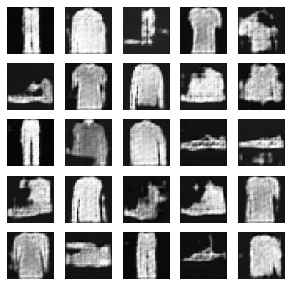

Epoch 2 - loss_d: 0.658, loss_g: 2.578


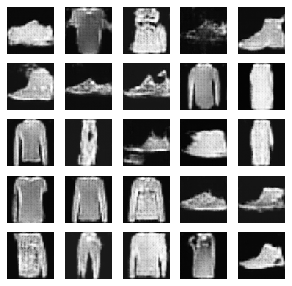

Epoch 3 - loss_d: 0.567, loss_g: 2.900


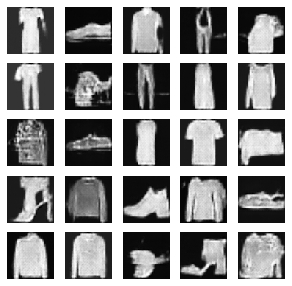

Epoch 4 - loss_d: 0.449, loss_g: 3.365


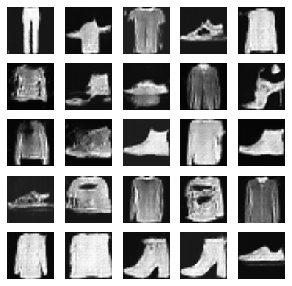

Epoch 5 - loss_d: 0.379, loss_g: 3.801


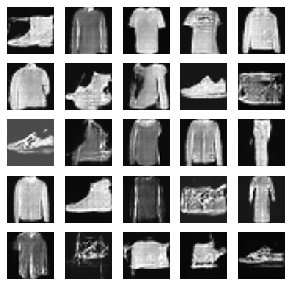

Epoch 6 - loss_d: 0.393, loss_g: 3.857


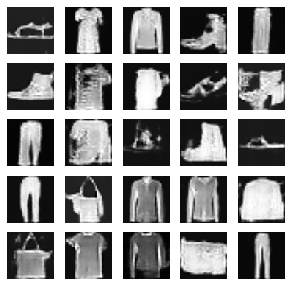

Epoch 7 - loss_d: 0.264, loss_g: 4.188


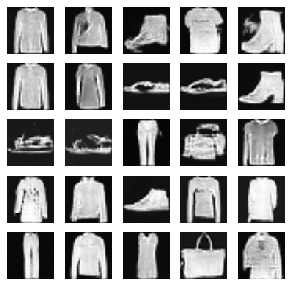

Epoch 8 - loss_d: 0.297, loss_g: 4.333


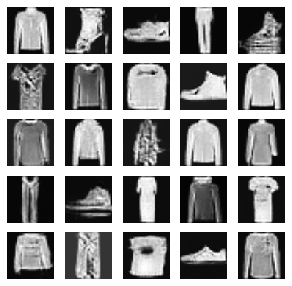

Epoch 9 - loss_d: 0.422, loss_g: 4.118


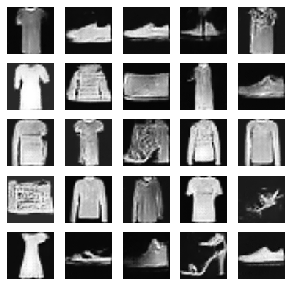

Epoch 10 - loss_d: 0.257, loss_g: 4.494


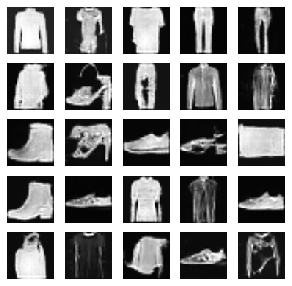

Epoch 11 - loss_d: 0.325, loss_g: 4.415


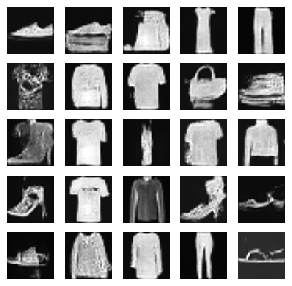

Epoch 12 - loss_d: 0.206, loss_g: 4.772


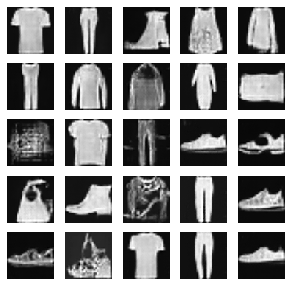

Epoch 13 - loss_d: 0.346, loss_g: 4.383


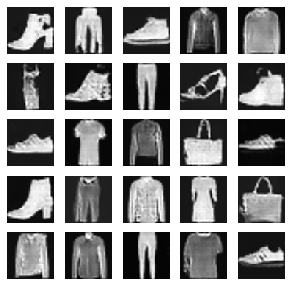

Epoch 14 - loss_d: 0.255, loss_g: 4.536


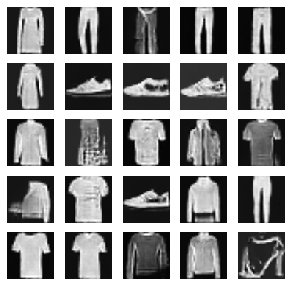

Epoch 15 - loss_d: 0.309, loss_g: 4.403


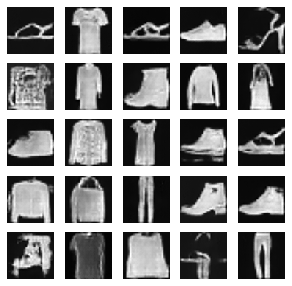

Epoch 16 - loss_d: 0.299, loss_g: 4.360


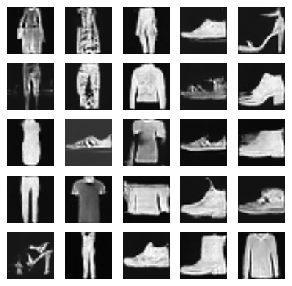

Epoch 17 - loss_d: 0.313, loss_g: 4.249


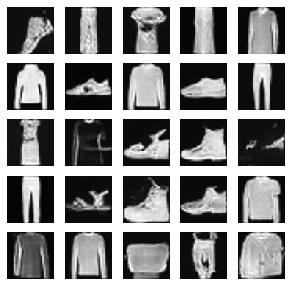

Epoch 18 - loss_d: 0.255, loss_g: 4.637


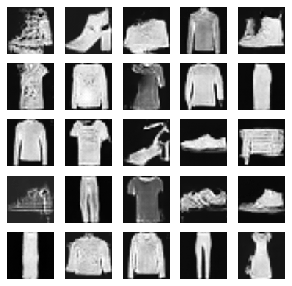

Epoch 19 - loss_d: 0.283, loss_g: 4.438


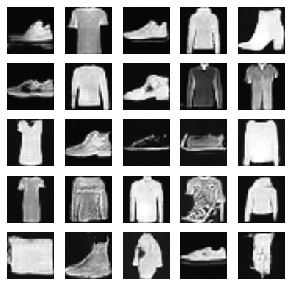

Epoch 20 - loss_d: 0.304, loss_g: 4.402


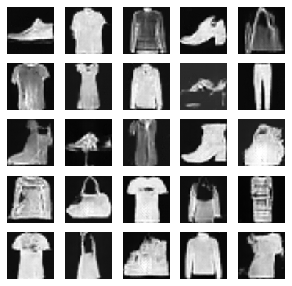

Epoch 21 - loss_d: 0.338, loss_g: 3.911


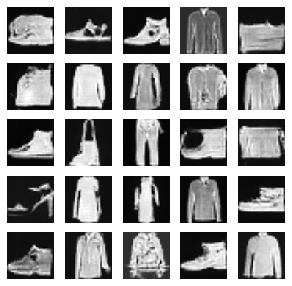

Epoch 22 - loss_d: 0.267, loss_g: 4.615


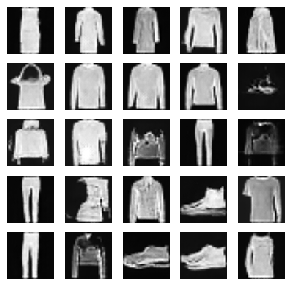

Epoch 23 - loss_d: 0.341, loss_g: 4.135


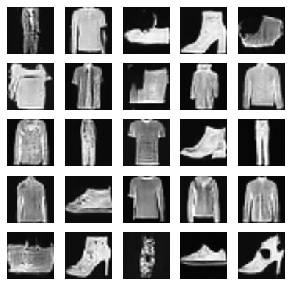

Epoch 24 - loss_d: 0.265, loss_g: 4.405


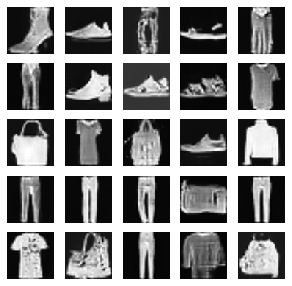

In [0]:
for epoch in range(n_epochs):
  
  D_losses = []
  G_losses = []
  
  for X, _ in train_loader:
    discriminator.zero_grad()
    mini_batch = X.size()[0]
    
    y_real_ = torch.ones(mini_batch)
    y_fake_ = torch.zeros(mini_batch)
    
    X = Variable(X.cuda())
    y_real_ = Variable(y_real_.cuda())
    y_fake_ = Variable(y_fake_.cuda())
    
    D_result = discriminator(X).squeeze()
    D_real_loss = BCE_loss(D_result, y_real_)
    
    z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)
    z_ = Variable(z_.cuda())
    G_result = generator(z_)
    
    D_result = discriminator(G_result).squeeze()
    D_fake_loss = BCE_loss(D_result, y_fake_)
    D_fake_score = D_result.data.mean()
    D_train_loss = D_real_loss + D_fake_loss
    
    D_train_loss.backward()
    D_optimizer.step()
    D_losses.append(D_train_loss)
    
    generator.zero_grad()
    
    z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)
    z_ = Variable(z_.cuda())
    
    G_result = generator(z_)
    D_result = discriminator(G_result).squeeze()
    G_train_loss = BCE_loss(D_result, y_real_)
    G_train_loss.backward()
    G_optimizer.step()
    G_losses.append(G_train_loss)
    
  print('Epoch {} - loss_d: {:.3f}, loss_g: {:.3f}'.format((epoch + 1),
                                                           torch.mean(torch.FloatTensor(D_losses)),
                                                           torch.mean(torch.FloatTensor(G_losses))))
  
  plot_output()